# Reconstruction of the ESCO skills pillar hierarchy

This notebook uses the [ESCO API](https://ec.europa.eu/esco/api/doc/esco_api_doc.html) to reconstruct the [ESCO skills hierarchy](https://ec.europa.eu/esco/portal/escopedia/Skills_pillar) (released in May 2020).

The final outputs are two tables: `ESCO_skills_concepts_hierarchy.csv` that captures the hierarchical structure of the ESCO skills categories, and `ESCO_skills_hierarchy.csv` that contains all items of the ESCO skills pillar and their position in the hierarchy.

**Warning**: With updates to the ESCO API, this hierarchy or the API are not guaranteed to stay the same. Therefore, we have stored backup results from the API calls (as they were in Summer 2020, when this analysis was carried out) in `data/interim/ESCO_API_skills`.

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble.ipy
from treelib import Node, Tree
import requests

skills = pd.read_csv(f'{data_folder}processed/ESCO_skills.csv')

# Specify the path where results from API calls are stored/saved
api_folder = f'{data_folder}interim/ESCO_API_skills/'

# Specify the outputs folder
outputs_folder = f'{data_folder}processed/ESCO_skills_hierarchy/'

# 1. Hierarchy levels for all skills

Here, we access all items of the ESCO skills pillar and check their place in the skills hierarchy.

## 1.1 API calls

In [106]:
# Use the API to get the hierarchy levels of all 13,000+ skills;
# Note that making all the API calls will take some time
# (alternatively, use the next cell to import the preloaded data)

all_broaderHierarchyConcepts = []
all_skill_uris = []

head_link = 'https://ec.europa.eu/esco/api'

# Load 20 skills at a time
offset = 0
count= 20
while count == 20:
    link = '/resource/skill?isInScheme=http://data.europa.eu/esco/concept-scheme/member-skills&language=en&limit=20&offset='+str(offset)    
    req = requests.get(head_link+link)

    list_of_uris = list(req.json()['_embedded'].keys())
    for j in range(len(list_of_uris)):
        
        k = list_of_uris[j]    
        keys = req.json()['_embedded'][k]['_links'].keys()
        if 'broaderHierarchyConcept' in keys:
            h = req.json()['_embedded'][k]['_links']['broaderHierarchyConcept']
            all_broaderHierarchyConcepts.append(h)
        else:
            all_broaderHierarchyConcepts.append([])

    count = req.json()['count']    
    offset += 20
    all_skill_uris += list_of_uris

pickle.dump(all_broaderHierarchyConcepts, open(api_folder + 'ESCO_skills_all_broaderHierarchyConcepts.pickle','wb'))
pickle.dump(all_skill_uris, open(api_folder + 'ESCO_skills_all_skill_uris.pickle','wb'))


In [2]:
# Import the preloaded skills hierarchy level data
all_broaderHierarchyConcepts = pickle.load(open(api_folder + 'ESCO_skills_all_broaderHierarchyConcepts.pickle','rb'))
all_skill_uris = pickle.load(open(api_folder + 'ESCO_skills_all_skill_uris.pickle','rb'))


## 1.2 Create a dataframe with skill hierarchy levels

In [3]:
n = len(all_broaderHierarchyConcepts)

all_titles = ['']*n
all_uris = ['']*n
all_hrefs = ['']*n
all_codes = ['']*n

for j, h in enumerate(all_broaderHierarchyConcepts):
    if len(h) != 0:
        all_titles[j] = h[0]['title']
        all_uris[j] = h[0]['uri']    
        all_hrefs[j] = h[0]['href']
        if 'code' in list(h[0].keys()):
            all_codes[j] = h[0]['code']
            
print(f'We have hierarchy codes for {len(all_codes)} skills')

We have hierarchy codes for 13485 skills


In [4]:
# Get the different hierarchy level codes for each skill
level_1 = ['']*n
level_2 = ['']*n
level_3 = ['']*n
skill_type = ['']*n

for j, code in enumerate(all_codes):
    if len(code) != 0:
        levels = code.split('.')
        skill_type[j] = levels[0][0]
        level_1[j] = levels[0]
        if len(levels)>1:
            level_2[j] = levels[0] + '.' + levels[1]
        if len(levels)>2:
            level_3[j] = levels[0] + '.' + levels[1] + '.' + levels[2]
            
# Create a dataframe storing skills' hierarchy levels
skill_hierarchy = pd.DataFrame(data={
    'concept_uri': all_skill_uris,
    'code': all_codes,
    'skill_category': skill_type,
    'level_1': level_1,
    'level_2': level_2,
    'level_3': level_3,
    'level_title': all_titles,
    'level_href': all_hrefs
})

# Link the data to the main skills dataframe
skills_ = skills.merge(skill_hierarchy, on='concept_uri', how='left')            

In [5]:
skills_.sample(3)

,concept_type,concept_uri,skill_type,reuse_level,preferred_label,alt_labels,description,id,code,skill_category,level_1,level_2,level_3,level_title,level_href
5155,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/60a63e4c-f71d...,skill/competence,sector-specific,analyse psychological aspects of illness,analyse mental aspects of illness\nanalyse psy...,Analyse the psychological impact of illness on...,5155,S3.2.4,S,S3,S3.2,S3.2.4,providing psychological and occupational thera...,https://ec.europa.eu/esco/api/resource/concept...
495,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/09d48285-7d78...,skill/competence,occupation-specific,encourage healthy behaviours,advocate healthy lifestyle\nencourage behaviou...,Encourage the adoption of healthy behaviours s...,495,S1.5.4,S,S1,S1.5,S1.5.4,providing medical advice,https://ec.europa.eu/esco/api/resource/concept...
1347,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/19bf58ed-23b8...,skill/competence,sector-specific,promote gender equality in business contexts,promoting gender equality in business contexts...,Raise awareness and campaign for the equalisat...,1347,S3.3.3,S,S3,S3.3,S3.3.3,complying with legal and organisational guidel...,https://ec.europa.eu/esco/api/resource/concept...


# 2. Reconstruct the skills concepts hierarchy

Here, we get all labels and relationships between the different categories and levels of the ESCO skills hierarchy, and create a dataframe describing each skills position in the hierarchy.

## 2.1 API calls

In [6]:
# Main link to use for calling API
# (alternatively, use the next cell to import the preloaded data)

main_link = 'https://ec.europa.eu/esco/api/resource/concept?uri='

# Create a queue of URIs to explore the hierarchy
concept_queue = ['http://data.europa.eu/esco/skill/S',
                 'http://data.europa.eu/esco/skill/A',
                 'http://data.europa.eu/esco/skill/L',
                 'http://data.europa.eu/esco/skill/K']

# Concepts dataframe
concepts = pd.DataFrame(data={
    'title': [],
    'code': [],
    'description': [],
    'uri': [],
    'broader_concept_uri': []
})

# Explore the hierarchy
while len(concept_queue) > 0:
    
    concept = concept_queue.pop()
    
    concept_dict = dict()
    
    # API call
    req = requests.get(main_link + concept)
    r = req.json()
    
    # Save concept information
    concept_dict['title'] = r['title']
    concept_dict['uri'] = r['uri']
    
    if code in list(r.keys()):
        concept_dict['code'] = r['code']
    else:
        concept_dict['code'] = ''
        
    if 'description' in list(r.keys()):
        concept_dict['description'] = r['description']
    else:
        concept_dict['description'] = ''
    
    # Save information about other higher/lower level concepts
    keys = list(r['_links'].keys())
    
    # Higher level concepts
    if 'broaderConcept' in keys:
        if len(r['_links']['broaderConcept']) == 1:
            concept_dict['broader_concept_uri'] = r['_links']['broaderConcept'][0]['uri']
        else:
            # In principle, this should never happen... but just for safety
            broader_concepts = []
            for broader_concept in r['_links']['broaderConcept']:
                broader_concepts.append(broader_concept['uri'])
            concept_dict['broader_concept_uri'] = str(broader_concepts)
    else:
        # No broader concept
        concept_dict['broader_concept_uri'] = 'is_top'
    
    # Lower level concepts (add to the queue)
    if 'narrowerConcept' in keys:
        for narrower_concept in r['_links']['narrowerConcept']:
            concept_queue.append(narrower_concept['uri'])
    
    concepts = concepts.append(concept_dict, ignore_index=True)
    print(f"{concept}: {concept_dict['title']}")

http://data.europa.eu/esco/skill/K: knowledge
http://data.europa.eu/esco/isced-f/02: arts and humanities
http://data.europa.eu/esco/isced-f/022: humanities (except languages)
http://data.europa.eu/esco/isced-f/0220: humanities (except languages) not further defined
http://data.europa.eu/esco/isced-f/0221: religion and theology
http://data.europa.eu/esco/isced-f/0222: history and archaeology
http://data.europa.eu/esco/isced-f/0228: inter-disciplinary programmes and qualifications involving humanities
http://data.europa.eu/esco/isced-f/0229: humanities (except languages) not elsewhere classified
http://data.europa.eu/esco/isced-f/0223: philosophy and ethics
http://data.europa.eu/esco/isced-f/029: arts and humanities not elsewhere classified
http://data.europa.eu/esco/isced-f/0299: arts and humanities not elsewhere classified
http://data.europa.eu/esco/isced-f/028: inter-disciplinary programmes and qualifications involving arts and humanities
http://data.europa.eu/esco/isced-f/0288: inter

http://data.europa.eu/esco/isced-f/101: personal services
http://data.europa.eu/esco/isced-f/1011: domestic services
http://data.europa.eu/esco/isced-f/1010: personal services not further defined
http://data.europa.eu/esco/isced-f/1015: travel, tourism and leisure
http://data.europa.eu/esco/isced-f/1014: sports
http://data.europa.eu/esco/isced-f/1019: personal services not elsewhere classified
http://data.europa.eu/esco/isced-f/1013: hotel, restaurants and catering
http://data.europa.eu/esco/isced-f/1012: hair and beauty services
http://data.europa.eu/esco/isced-f/100: services not further defined
http://data.europa.eu/esco/isced-f/1000: services not further defined
http://data.europa.eu/esco/isced-f/03: social sciences, journalism and information
http://data.europa.eu/esco/isced-f/032: journalism and information
http://data.europa.eu/esco/isced-f/0320: journalism and information not further defined
http://data.europa.eu/esco/isced-f/0322: library, information and archival studies
http

http://data.europa.eu/esco/isced-f/0819: agriculture not elsewhere classified
http://data.europa.eu/esco/isced-f/0811: crop and livestock production
http://data.europa.eu/esco/isced-f/089: agriculture, forestry, fisheries and veterinary not elsewhere classified
http://data.europa.eu/esco/isced-f/0899: agriculture, forestry, fisheries and veterinary not elsewhere classified
http://data.europa.eu/esco/isced-f/080: agriculture, forestry, fisheries and veterinary not further defined
http://data.europa.eu/esco/isced-f/0800: agriculture, forestry, fisheries and veterinary not further defined
http://data.europa.eu/esco/isced-f/084: veterinary
http://data.europa.eu/esco/isced-f/0841: veterinary
http://data.europa.eu/esco/isced-f/088: inter-disciplinary programmes and qualifications involving  agriculture, forestry, fisheries and veterinary
http://data.europa.eu/esco/isced-f/0888: inter-disciplinary programmes and qualifications involving  agriculture, forestry, fisheries and veterinary
http://

http://data.europa.eu/esco/skill/S2.3.0: managing information
http://data.europa.eu/esco/skill/S4: management skills
http://data.europa.eu/esco/skill/S4.9: making decisions
http://data.europa.eu/esco/skill/S4.9.0: making decisions
http://data.europa.eu/esco/skill/S4.5: leading and motivating
http://data.europa.eu/esco/skill/S4.5.0: leading and motivating
http://data.europa.eu/esco/skill/S4.6: building and developing teams
http://data.europa.eu/esco/skill/S4.6.0: building and developing teams
http://data.europa.eu/esco/skill/S4.8: supervising people
http://data.europa.eu/esco/skill/S4.8.0: supervising people
http://data.europa.eu/esco/skill/S4.8.1: supervising a team or group
http://data.europa.eu/esco/skill/S4.8.3: monitoring and evaluating the performance of individuals
http://data.europa.eu/esco/skill/S4.8.2: assigning work to others
http://data.europa.eu/esco/skill/S4.1: developing objectives and strategies
http://data.europa.eu/esco/skill/S4.1.1: identifying opportunities
http://da

http://data.europa.eu/esco/skill/S1.8.5: following instructions and procedures
http://data.europa.eu/esco/skill/S1.8.2: giving instructions
http://data.europa.eu/esco/skill/S1.8.6: assisting and supporting co-workers
http://data.europa.eu/esco/skill/S1.9: solving problems
http://data.europa.eu/esco/skill/S1.9.1: developing solutions
http://data.europa.eu/esco/skill/S1.9.0: solving problems
http://data.europa.eu/esco/skill/S1.9.2: implementing new procedures or processes
http://data.europa.eu/esco/skill/S1.7: obtaining information verbally
http://data.europa.eu/esco/skill/S1.7.3: listening and asking questions
http://data.europa.eu/esco/skill/S1.7.2: engaging with others to identify needs
http://data.europa.eu/esco/skill/S1.7.1: interviewing
http://data.europa.eu/esco/skill/S1.7.0: obtaining information verbally
http://data.europa.eu/esco/skill/S1.3: teaching and training
http://data.europa.eu/esco/skill/S1.3.3: training on operational procedures
http://data.europa.eu/esco/skill/S1.3.4:

http://data.europa.eu/esco/skill/S8.6.2: operating audio-visual equipment
http://data.europa.eu/esco/skill/S8.6.5: operating precision industrial equipment
http://data.europa.eu/esco/skill/S8.6.6: using precision measuring equipment
http://data.europa.eu/esco/skill/S8.6.0: using precision instrumentation and equipment
http://data.europa.eu/esco/skill/S8.6.4: operating communications equipment
http://data.europa.eu/esco/skill/S8.2: driving vehicles
http://data.europa.eu/esco/skill/S8.2.2: driving light vehicles
http://data.europa.eu/esco/skill/S8.2.0: driving vehicles
http://data.europa.eu/esco/skill/S8.2.1: driving heavy vehicles
http://data.europa.eu/esco/skill/S8.2.3: operating rail vehicles
http://data.europa.eu/esco/skill/S8.4: operating machinery for the extraction and processing of raw materials
http://data.europa.eu/esco/skill/S8.4.7: operating kilns, furnaces and drying equipment
http://data.europa.eu/esco/skill/S8.4.4: operating energy production or distribution equipment
http

http://data.europa.eu/esco/skill/S6.9.1: tending and breeding animals
http://data.europa.eu/esco/skill/S6.9.4: hunting, trapping and slaughtering animals
http://data.europa.eu/esco/skill/S6.9.0: handling animals
http://data.europa.eu/esco/skill/S6.9.6: training animals
http://data.europa.eu/esco/skill/S6.9.7: providing therapy or veterinary treatment for animals
http://data.europa.eu/esco/skill/S6.4: tending plants and crops
http://data.europa.eu/esco/skill/S6.4.2: planting crops, trees, or other plants
http://data.europa.eu/esco/skill/S6.4.1: cultivating land and crops
http://data.europa.eu/esco/skill/S6.4.0: tending plants and crops
http://data.europa.eu/esco/skill/S6.4.3: pruning, cutting and harvesting, trees crops and other plants


In [7]:
# Save a backup of the API responses
pickle.dump(concepts, open(api_folder + 'ESCO_skills_concepts.pickle','wb'))


In [6]:
# Import the preloaded skills concepts hierarchy data 
concepts = pickle.load(open(api_folder + 'ESCO_skills_concepts.pickle','rb'))


In [68]:
# Format the description column
concepts['description_en'] = concepts.description.apply(lambda x: x['en']['literal'] if type(x)==dict else x)
concepts_hierarchy = concepts.copy()
concepts_hierarchy.drop('description', axis=1, inplace=True)

In [69]:
concepts_hierarchy.head(3)

,title,code,uri,broader_concept_uri,description_en
0,knowledge,,http://data.europa.eu/esco/skill/K,is_top,
1,arts and humanities,,http://data.europa.eu/esco/isced-f/02,http://data.europa.eu/esco/skill/K,
2,humanities (except languages),,http://data.europa.eu/esco/isced-f/022,http://data.europa.eu/esco/isced-f/02,


In [70]:
concepts_hierarchy.tail(3)

,title,code,uri,broader_concept_uri,description_en
653,cultivating land and crops,,http://data.europa.eu/esco/skill/S6.4.1,http://data.europa.eu/esco/skill/S6.4,Preparing and maintaining land for agricultura...
654,tending plants and crops,,http://data.europa.eu/esco/skill/S6.4.0,http://data.europa.eu/esco/skill/S6.4,"Propagating, cultivating, pruning, caring for ..."
655,"pruning, cutting and harvesting, trees crops a...",,http://data.europa.eu/esco/skill/S6.4.3,http://data.europa.eu/esco/skill/S6.4,"Reducing the size, removing limbs, or cutting ..."


## 2.2 Create codes for knowledge categories

At the time of doing this analysis, the ESCO 'knowledge' items of the skills pillar don't have specified codes. For these, we create or own coding system that takes into account the broader/narrow concept hierarchy of the knowledge items.

In [71]:
def get_code(x):
    if x[0:33] == 'http://data.europa.eu/esco/skill/':
        return x[33:]
    else:
        return ''
    
concepts_hierarchy['code'] = concepts_hierarchy['uri'].apply(lambda x: get_code(x)) 

In [72]:
# Determine the different high level categories for each concept
concepts_hierarchy['category'] = 'K'
concepts_hierarchy.loc[ concepts_hierarchy.code!='', 'category'] = concepts_hierarchy.loc[concepts_hierarchy.code!='', 'code'].apply(lambda x: x[0])


In [73]:
# Create codes for each knowledge concept
top_concept_queue = ['http://data.europa.eu/esco/skill/K']

# Explore the hierarchy
while len(top_concept_queue) > 0:

    concept = top_concept_queue.pop()
    
    # Get the code
    code = concepts_hierarchy[concepts_hierarchy.uri == concept].code.values[0]
    
    children = concepts_hierarchy[concepts_hierarchy.broader_concept_uri==concept]
    children = children.copy().sort_values('uri').reset_index(drop=True)
    
    for j, row in children.iterrows():
        
        if len(code)==1:
            new_code = code + str(j)
        else:
            new_code = code + '.' + str(j)
            
        concepts_hierarchy.loc[concepts_hierarchy.uri==row.uri, 'code'] = new_code
        top_concept_queue.append(row.uri)

In [74]:
concepts_hierarchy

,title,code,uri,broader_concept_uri,description_en,category
0,knowledge,K,http://data.europa.eu/esco/skill/K,is_top,,K
1,arts and humanities,K2,http://data.europa.eu/esco/isced-f/02,http://data.europa.eu/esco/skill/K,,K
2,humanities (except languages),K2.2,http://data.europa.eu/esco/isced-f/022,http://data.europa.eu/esco/isced-f/02,,K
3,humanities (except languages) not further defined,K2.2.0,http://data.europa.eu/esco/isced-f/0220,http://data.europa.eu/esco/isced-f/022,,K
4,religion and theology,K2.2.1,http://data.europa.eu/esco/isced-f/0221,http://data.europa.eu/esco/isced-f/022,Religion and theology is the study of religiou...,K
...,...,...,...,...,...,...
651,tending plants and crops,S6.4,http://data.europa.eu/esco/skill/S6.4,http://data.europa.eu/esco/skill/S6,"Propagating, cultivating, pruning, caring for ...",S
652,"planting crops, trees, or other plants",S6.4.2,http://data.europa.eu/esco/skill/S6.4.2,http://data.europa.eu/esco/skill/S6.4,"Propagating and planting trees, flowers and ot...",S
653,cultivating land and crops,S6.4.1,http://data.europa.eu/esco/skill/S6.4.1,http://data.europa.eu/esco/skill/S6.4,Preparing and maintaining land for agricultura...,S
654,tending plants and crops,S6.4.0,http://data.europa.eu/esco/skill/S6.4.0,http://data.europa.eu/esco/skill/S6.4,"Propagating, cultivating, pruning, caring for ...",S


## 2.3 Final fine-tuning of the output tables

### 2.3.1 Concepts hierarchy dataframe

In [75]:
# Determine the level of the hierarchy for each concept
def determine_hierarchy_level(x):
    if len(x) == 1:
        return 0
    else:
        return len(x.split('.'))
    
concepts_hierarchy['hierarchy_level'] = concepts_hierarchy.code.apply(lambda x: determine_hierarchy_level(x))

In [76]:
# Add broader concept codes
concepts_hierarchy['broader_concept_code'] = concepts_hierarchy.merge(
    concepts_hierarchy[['code','uri']],
    left_on='broader_concept_uri', right_on='uri', how='left').code_y.to_list()

concepts_hierarchy.loc[concepts_hierarchy.broader_concept_code.isnull(),'broader_concept_code'] = 'is_top'


In [77]:
# Reorganise columns
concepts_hierarchy = concepts_hierarchy[['title', 'category', 'code', 'description_en',
                                         'hierarchy_level', 'broader_concept_code',
                                         'uri', 'broader_concept_uri']]


In [78]:
concepts_hierarchy.head(3)

,title,category,code,description_en,hierarchy_level,broader_concept_code,uri,broader_concept_uri
0,knowledge,K,K,,0,is_top,http://data.europa.eu/esco/skill/K,is_top
1,arts and humanities,K,K2,,1,K,http://data.europa.eu/esco/isced-f/02,http://data.europa.eu/esco/skill/K
2,humanities (except languages),K,K2.2,,2,K2,http://data.europa.eu/esco/isced-f/022,http://data.europa.eu/esco/isced-f/02


### 2.3.2 Skills dataframe

In [79]:
# Account for knowledge and language-use skills
skills_final = skills_.copy()

# Knowledge skills
x = (skills_.skill_category == '') & (skills_.skill_type == 'knowledge')
print(f'There are {np.sum(x)} knowledge types')
skills_final.loc[x,'skill_category'] = 'K'

# Language-using skills
x = (skills_.skill_category == '') & (skills_.skill_type == 'skill/competence')
print(f'There are {np.sum(x)} language skills')
skills_final.loc[x,'skill_category'] = 'L_use'

# Add the knowledge codes
skills_final['level_uri'] = skills_final.level_href.apply(lambda x: x[51:])

df = skills_final[skills_final.skill_category=='K'].merge(
    concepts_hierarchy[['uri','code']],
    left_on='level_uri', right_on='uri', how='left')
skills_final.loc[skills_final.skill_category=='K','code'] = df.code_y.to_list()


There are 2834 knowledge types
There are 285 language skills


### Knowledge items: Take care of null values in the `code` column by hand

There are two knowledge items that are even below a Level-3 knowledge type. We all assign them to the same category as their higher-level knowledge type

In [80]:
null_df = skills_final[skills_final.code.isnull()]
null_df

,concept_type,concept_uri,skill_type,reuse_level,preferred_label,alt_labels,description,id,code,skill_category,level_1,level_2,level_3,level_title,level_href,level_uri
4794,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/5a234b3b-63b4...,knowledge,sector-specific,office equipment,office machinery\nequipment found in offices\n...,The offered office machinery and equipment pro...,4794,NaN,K,,,,,,
13385,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/fe30a4b0-1a99...,knowledge,cross-sector,communication principles,communication theories\ncommunication ideals\n...,The set of commonly shared principles in regar...,13385,NaN,K,,,,,,


In [81]:
main_link = 'https://ec.europa.eu/esco/api/resource/concept?uri='
broader_skills = []
for j, row in null_df.iterrows():
    concept = row.concept_uri
    req = requests.get(main_link + concept)
    r = req.json()
    broader_skills.append(r['_links']['broaderSkill'])

In [82]:
codes = []
titles = []
for broader_skills_list in broader_skills:
    codes_list = []
    title_list = []
    for b in broader_skills_list:
        title_list.append(skills_final[skills_final.concept_uri==b['uri']].preferred_label.values[0])
        codes_list.append(skills_final[skills_final.concept_uri==b['uri']].id.values[0])
    codes.append(codes_list)
    titles.append(title_list)

In [83]:
codes, titles

([[11313], [8783, 4652]],
 [['product comprehension'], ['teamwork principles', 'diplomatic principles']])

In [84]:
# Assign the knowledge types without code to the same cluster as their higher-level knowledge types
# (communication principles we arbitrarily assign to teamwork principles)
adaptation_list = [[4794, 11313], [13385, 8783]]

In [85]:
cols_to_adapt = ['code', 'skill_category', 'level_1', 'level_2', 'level_3', 'level_title']
for pair in adaptation_list:
    for col in cols_to_adapt:
        skills_final.loc[pair[0], col] = skills_final.loc[pair[1], col]

In [86]:
len(skills_final[skills_final.code.isnull()])

0

### Knowledge items:  Add values in `level` columns for knowledge items

In [87]:
df = skills_final[skills_final.skill_category=='K'].copy()
all_codes = df.code.to_list()
n = len(all_codes)

# Get the different hierarchy level codes for each skill
level_1 = ['']*n
level_2 = ['']*n
level_3 = ['']*n

for j, code in enumerate(all_codes):
    if len(code) != 0:
        levels = code.split('.')
        level_1[j] = levels[0]
        if len(levels)>1:
            level_2[j] = levels[0] + '.' + levels[1]
        if len(levels)>2:
            level_3[j] = levels[0] + '.' + levels[1] + '.' + levels[2]
            
skills_final.loc[df.id.to_list(), 'level_1'] = level_1
skills_final.loc[df.id.to_list(), 'level_2'] = level_2
skills_final.loc[df.id.to_list(), 'level_3'] = level_3

In [88]:
skills_final


,concept_type,concept_uri,skill_type,reuse_level,preferred_label,alt_labels,description,id,code,skill_category,level_1,level_2,level_3,level_title,level_href,level_uri
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,sector-specific,manage musical staff,manage staff of music\ncoordinate duties of mu...,Assign and manage staff tasks in areas such as...,0,S4.8.1,S,S4,S4.8,S4.8.1,supervising a team or group,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S4.8.1
1,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00064735-8fad...,skill/competence,occupation-specific,supervise correctional procedures,oversee prison procedures\nmanage correctional...,Supervise the operations of a correctional fac...,1,S4.2.1,S,S4,S4.2,S4.2.1,directing operational activities,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S4.2.1
2,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/000709ed-2be5...,skill/competence,sector-specific,apply anti-oppressive practices,apply non-oppressive practices\napply an anti-...,"Identify oppression in societies, economies, c...",2,S3.3.0,S,S3,S3.3,S3.3.0,protecting and enforcing,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S3.3.0
3,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0007bdc2-dd15...,skill/competence,sector-specific,control compliance of railway vehicles regulat...,monitoring of compliance with railway vehicles...,"Inspect rolling stock, components and systems ...",3,S3.3.3,S,S3,S3.3,S3.3.3,complying with legal and organisational guidel...,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S3.3.3
4,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00090cc1-1f27...,skill/competence,cross-sector,identify available services,establish available services\ndetermine rehabi...,Identify the different services available for ...,4,S3.1.3,S,S3,S3.1,S3.1.3,assisting people to access services,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S3.1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/ffef5eb3-a15e...,skill/competence,sector-specific,remediate healthcare user's occupational perfo...,restore healthcare user's occupational perform...,"Remediate or restore the cognitive, sensorimot...",13480,S3.2.4,S,S3,S3.2,S3.2.4,providing psychological and occupational thera...,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S3.2.4
13481,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/fff0b074-5a76...,skill/competence,sector-specific,install transport equipment lighting,install transport equipment illumination\nfix ...,Install lighting elements in transport equipme...,13481,S8.8.1,S,S8,S8.8,S8.8.1,"installing and repairing electrical, electroni...",https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S8.8.1
13482,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/fff0e2cd-d0bd...,knowledge,sector-specific,natural language processing,NLP,The technologies which enable ICT devices to u...,13482,K2.3.1,K,K2,K2.3,K2.3.1,language acquisition,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/isced-f/0231
13483,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/fff5bc45-b506...,skill/competence,cross-sector,coordinate construction activities,construction progress review\ncoordination of ...,Coordinate the activities of several construct...,13483,S1.2.1,S,S1,S1.2,S1.2.1,coordinating activities with others,https://ec.europa.eu/esco/api/resource/concept...,http://data.europa.eu/esco/skill/S1.2.1


## 2.4. Count the number of skills pillar items at each level

In [89]:
no_elements = [0] * len(concepts_hierarchy)
for i, row in concepts_hierarchy.iterrows():
    if row.hierarchy_level == 0:
        no_elements[i] = len(skills_final[skills_final.skill_category == row.code])
    else:
        level = str(row.hierarchy_level)
        no_elements[i] = len(skills_final[skills_final['level_'+level]==row.code])

In [90]:
# Add number of elements to the concepts hierarchy dataframe
concepts_hierarchy = concepts_hierarchy.copy()
concepts_hierarchy['number_of_items'] = no_elements

concepts_hierarchy.sample(5)

,title,category,code,description_en,hierarchy_level,broader_concept_code,uri,broader_concept_uri,number_of_items
29,"engineering, manufacturing and construction no...",K,K7.0,,2,K7,http://data.europa.eu/esco/isced-f/070,http://data.europa.eu/esco/isced-f/07,0
60,accounting and taxation,K,K4.1.1,Accounting and taxation is the study of mainta...,3,K4.1,http://data.europa.eu/esco/isced-f/0411,http://data.europa.eu/esco/isced-f/041,13
313,"preparing documentation for contracts, applica...",S,S2.2.3,Preparing applications and maintaining standar...,3,S2.2,http://data.europa.eu/esco/skill/S2.2.3,http://data.europa.eu/esco/skill/S2.2,36
122,social and behavioural sciences,K,K3.1,,2,K3,http://data.europa.eu/esco/isced-f/031,http://data.europa.eu/esco/isced-f/03,94
184,"natural sciences, mathematics and statistics n...",K,K5.0.0,,3,K5.0,http://data.europa.eu/esco/isced-f/0500,http://data.europa.eu/esco/isced-f/050,0


## 2.5 Export tables

In [91]:
# Table with the hierarchy structure
concepts_hierarchy.sort_values('code').to_csv(f'{outputs_folder}ESCO_skills_concepts_hierarchy.csv', index=False)

# Table with skills and their position in the hierarchy levels
skills_final.to_csv(f'{outputs_folder}ESCO_skills_hierarchy.csv', index=False)

# 3. Inspect the hierarchy
 

In [92]:
concepts_hierarchy = pd.read_csv(f'{outputs_folder}ESCO_skills_concepts_hierarchy.csv')
skills_final = pd.read_csv(f'{outputs_folder}ESCO_skills_hierarchy.csv')

## 3.1 Check the least and most prominent categories

78 categories without items


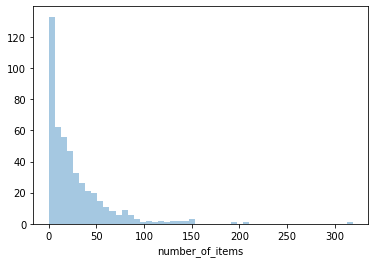

In [93]:
# Note that there are categories without any skills pillar items
df = concepts_hierarchy[concepts_hierarchy.hierarchy_level==3]
print(f"{len(df[df.number_of_items==0])} categories without items")

sns.distplot(concepts_hierarchy[concepts_hierarchy.hierarchy_level==3].number_of_items, bins=50, kde=False)
plt.show()

In [94]:
# Show the number of skills pillar items in each top level category  
level_1_counts = skills_final.groupby('level_1').count()[['id']]
level_1_counts['code'] = level_1_counts.index.to_list()
level_1_counts = level_1_counts.merge(concepts_hierarchy[['code', 'title']], on='code').sort_values('id', ascending=False)
level_1_counts


,id,code,title
16,2318,S1,"communication, collaboration and creativity"
17,2008,S2,information skills
21,1464,S6,handling and moving
23,1369,S8,working with machinery and specialised equipment
19,1317,S4,management skills
18,1056,S3,assisting and caring
11,794,K7,"engineering, manufacturing and construction"
13,374,K9,health and welfare
8,341,K4,"business, administration and law"
20,300,S5,working with computers


In [95]:
concepts_hierarchy[concepts_hierarchy.broader_concept_code=='K10'].sort_values('code')[['title','code','description_en']]


,title,code,description_en
72,services not further defined,K10.0,NaN
74,personal services,K10.1,NaN
82,hygiene and occupational health services,K10.2,NaN
87,security services,K10.3,NaN
92,transport services,K10.4,NaN
94,inter-disciplinary programmes and qualificatio...,K10.5,NaN
96,services not elsewhere classified,K10.6,NaN


## 3.2 Visualise the hierarchy

In [96]:
def create_tree(max_level=3):
    tree = Tree()
    # Create the base node
    tree.create_node("esco skills", "is_top")
    # Add all nodes
    for i, row in concepts_hierarchy.sort_values('code').iterrows():
        if row.hierarchy_level <= max_level:
            tree.create_node(f"{row.code}: {row.title} [{row.number_of_items}]", row.code, parent=row.broader_concept_code)
    return tree 

In [98]:
tree = create_tree(3)
tree.show()

esco skills
├── A: attitudes and values [174]
│   ├── A1: attitudes [140]
│   │   ├── A1.0: attitudes [0]
│   │   │   └── A1.0.0: attitudes [0]
│   │   ├── A1.10: manage frustration [2]
│   │   │   └── A1.10.0: manage frustration [2]
│   │   ├── A1.12: manage quality [43]
│   │   │   ├── A1.12.0: manage quality [1]
│   │   │   ├── A1.12.1: assure quality of processes and products [20]
│   │   │   ├── A1.12.2: apply quality standards [14]
│   │   │   └── A1.12.3: provide high quality client service [8]
│   │   ├── A1.13: meet commitments [19]
│   │   │   ├── A1.13.0: meet commitments [3]
│   │   │   ├── A1.13.1: meet deadlines and follow schedules [11]
│   │   │   ├── A1.13.2: assume responsibility [4]
│   │   │   └── A1.13.3: stay within budget [1]
│   │   ├── A1.14: persist [15]
│   │   │   └── A1.14.0: persist [15]
│   │   ├── A1.15: work efficiently [5]
│   │   │   └── A1.15.0: work efficiently [5]
│   │   ├── A1.16: work independently [9]
│   │   │   └── A1.16.0: work independently